In [1]:
import numpy as np
import itertools
from graphviz import Digraph
import networkx as nx

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True)

In [2]:
class DMG():
    def __init__(self, nodes, edges, ommited_nodes = []):
        self.nodes = nodes
        self.ommited_nodes = ommited_nodes
        self.all_nodes = nodes + ommited_nodes
        
        self.edges = edges
        
        self.N_nodes = len(nodes)
        self.N_ommited = len(self.ommited_nodes)
        self.N_total = len(self.all_nodes)
        
        self.var_to_int = {}
        self.int_to_var = {}
        self.str_to_var = {}

        self.Lambda = np.zeros((self.N_nodes, self.N_nodes))
        self.full_Lambda = np.zeros((self.N_total, self.N_total))
        
        self.Omega = np.zeros((self.N_nodes, self.N_nodes))
        self.Sigma = np.zeros((self.N_nodes, self.N_nodes))

        self.HTC_identified = False
        
        self.create_variables()

    
    def generate_parameters(self, p):  
        self.gen_Lambda(p)
        self.set_siblings()
        self.gen_Omega()
        self.gen_Sigma()
        
        
    def create_variables(self):
        self.variables = []
        self.ommited_variables = []

        for index, node in enumerate(self.nodes):
            # instantiate variable
            variable = Variable(node)
            self.variables.append(variable)
            self.var_to_int[variable] = index
            self.int_to_var[index] = variable
            self.str_to_var[node] = variable

        for o_node in self.ommited_nodes:
            # create ommited variables
            variable = Variable(o_node, True)
            self.ommited_variables.append(variable)

        self.all_variables = self.variables + self.ommited_variables

        return self.variables


    def gen_Lambda(self):
        for row_id, row_var in enumerate(self.all_variables):
            for col_id, col_var in enumerate(self.all_variables):
                for edge in self.edges:
                    # if row variable is a parent of the column variable
                    if row_var.name == edge[0] and col_var.name == edge[1]:
                        # set parent-child relation and set the lambda value
                        value = col_var.add_parent(row_var, p)
                        row_var.add_child(col_var)
                        self.full_Lambda[row_id][col_id] = value

        self.Lambda = self.full_Lambda[:self.N_nodes, :self.N_nodes]

        return self.Lambda


    def gen_Omega(self):
        for row_id, row_var in enumerate(self.variables):
            for col_id, col_var in enumerate(self.variables):
                o_parents = row_var.get_parents(p_dict="ommited")

                # set the variances on the diagonal
                if row_id == col_id:
                    self.Omega[row_id][col_id] = row_var.true_sd**2

                    for parent in o_parents:
                        # adjust the variance if the variable has ommited parents
                        lambd = col_var.all_parents[parent]
                        self.Omega[row_id][col_id] += lambd**2 * parent.true_sd**2

                # set the covariances 
                for parent in o_parents:
                    # check if both variables have the same ommite parents
                    if parent in col_var.all_parents and col_id != row_id:
                        lambd1 = col_var.all_parents[parent]
                        lambd2 = row_var.all_parents[parent]
                        self.Omega[row_id][col_id] = lambd1 * lambd2 * parent.true_sd**2
        

        return self.Omega

    
    def set_siblings(self):
        # go trough each pair of variables
        for var1_id, var1 in enumerate(self.variables):
            for var2 in self.variables[var1_id + 1:]:
                for o_parent in var1.o_parents:
                    # for each variable, check if they have the same ommited parents
                    if o_parent in var2.o_parents:
                        # set sibling status for both variables
                        var1.add_sibling(var2)
                        var2.add_sibling(var1)

        return self.variables


    def gen_variable_values(self, n):
        # invert the I - lambda' matrix
        ILambd = np.identity(self.N_total) - self.full_Lambda.transpose(1,0)
        ILambd_inv = np.linalg.inv(ILambd)

        # create constant vector and error matrix
        constant = np.zeros(self.N_total)
        error = np.zeros((self.N_total, n))

        for idx, variable in enumerate(self.all_variables):
            error[idx,:] = variable.gen_errors(n)
            constant[idx] = variable.true_c
        
        # calculate the values
        sum_ = constant[:, np.newaxis] + error
        self.values = np.matmul(ILambd_inv, sum_)
            
        return self.values

    
    def gen_Sigma(self):
        if not self.Lambda.any():
            self.gen_Lambda()
        if not self.Omega.any():
            self.gen_Omega()

        ILambd = np.identity(self.N_nodes) - self.Lambda
        ILambd_inv = np.linalg.inv(ILambd)

        self.Sigma = np.matmul(ILambd_inv.transpose(1, 0), np.matmul(self.Omega, ILambd_inv))

        return self.Sigma

    
    def estimate_Sigma(self):
        self.Sigma_est = np.cov(self.values)[:self.N_nodes, :self.N_nodes]

        return self.Sigma_est
        

    def get_half_treks(self, nodeA, nodeB):
        half_treks = []
        
        paths = [[(nodeA, "s")]]

        if nodeA == nodeB:
            half_treks.append([(nodeA, "s")])
        
        for sibling in nodeA.siblings:
            if sibling == nodeB:
                half_treks.append([(nodeA, "s"), (nodeB, "b")])
            else:
                paths.append([(nodeA, "s"), (sibling, "b")])

        while paths:
            path = paths.pop(0)
            
            last_node = path[-1][0]
            
            for child in last_node.children:
                if child == nodeB:
                    half_treks.append(path + [(child, "r")])

                elif not (child, "r") in path:
                    paths.append(path + [(child, "r")])


        return half_treks

    
    def htr(self, nodeA):
        htr = []
        for var in self.variables:
            if var != nodeA and not var in nodeA.siblings:
                treks = self.get_half_treks(nodeA, var)
                
                if treks:
                    htr.append(var)

        return htr
                    

    def HTC_identifiable(self):
        if self.HTC_identified:
            HTC_identifiable = len(self.HTC_order) == len(self.variables)
            
            return HTC_identifiable

        self.HTC_order = []
        change = True
        
        for var in self.variables:
            if len(var.parents) == 0:
                self.HTC_order.append(var)        

        while change == True and len(self.HTC_order) != len(self.variables):
            change = False
            
            for v in self.variables:
                if not v in self.HTC_order:
                    htr_v = self.htr(v)
                    v_min_htr = set(self.variables) - set(htr_v)
                    A = (v_min_htr | set(self.HTC_order)) - set([v]) - set(v.siblings)

                    max_flow, flow_dict = self.max_flow(v, A)

                    if max_flow == len(v.parents):

                        # Save the set of HTC identifiable nodes 
                        for node in flow_dict["s"]:
                            if flow_dict["s"][node] == 1:
                                Yv = self.str_to_var[node[2]]
                                v.add_Yv(Yv)

                        # Add variable to solved nodes
                        self.HTC_order.append(v)
                        change = True

        HTC_identifiable = len(self.HTC_order) == len(self.variables)
        self.HTC_identified = True
        
        return HTC_identifiable
        

    def max_flow(self, v, A):
        g = nx.DiGraph()

        g.add_edge("s", "t", capacity=0)

        for var in A:            
            g.add_edge("s", f"l_{var.name}_in")
            g.add_edge(f"l_{var.name}_out", f"r_{var.name}_in")
        
            for sibling in var.siblings:
                g.add_edge(f"l_{var.name}_out", f"r_{sibling.name}_in")

        for var in self.variables:
            g.add_edge(f"l_{var.name}_in", f"l_{var.name}_out", capacity=1)
            g.add_edge(f"r_{var.name}_in", f"r_{var.name}_out", capacity=1)
            
            for child in var.children: 
                g.add_edge(f"r_{var.name}_out", f"r_{child.name}_in")

        for parent in v.parents:
            g.add_edge(f"r_{parent.name}_out", "t")

        flow_value, flow_dict = nx.maximum_flow(g, 's', 't')
        
        return flow_value, flow_dict

    def estimate_Lambda(self, Sigma):
        HTC_identifiable = self.HTC_identifiable()
        # if HTC_identifiable == False:
        #     raise Exception("Graph not HTC idenifiable")

        self.Lambda_est = np.zeros((self.N_nodes, self.N_nodes))

        for var in self.HTC_order:
            A = np.zeros((len(var.Yv), len(var.Yv)))
            b = np.zeros(len(var.Yv))
            
            for row_id, y in enumerate(var.Yv):
                for col_id, parent in enumerate(var.parents):
                    y_id = self.var_to_int[y]
                    parent_id = self.var_to_int[parent]
                    var_id = self.var_to_int[var]

                    I_min_lamb_T = (np.identity(self.N_nodes) - self.Lambda_est).transpose(1,0)
                    
                    if y in self.htr(var):
                        A[row_id][col_id] = np.matmul(I_min_lamb_T[y_id, :], Sigma[:, parent_id])
                        b[row_id] = np.matmul(I_min_lamb_T[y_id, :], Sigma[:, var_id])
                    else:
                        A[row_id][col_id] = Sigma[y_id][parent_id]
                        b[row_id] = Sigma[y_id][var_id]

            Lambda_parents = np.matmul(np.linalg.inv(A), b)
            
            for indx, parent in enumerate(var.parents):
                parent_id = self.var_to_int[parent]
                self.Lambda_est[parent_id][var_id] = Lambda_parents[indx]

        return self.Lambda_est

    def estimate_Omega(self, Sigma):
        I_min_lamb = (np.identity(self.N_nodes) - self.Lambda_est)
        
        self.Omega_est = np.matmul(I_min_lamb.transpose(1, 0), np.matmul(Sigma, I_min_lamb))

        return self.Omega_est


In [3]:
class Variable():
    def __init__(self, name, ommited=False):
        self.name = name
        self.all_parents = {}
        self.o_parents = {}
        self.parents = {}
        self.children = {}
        self.siblings = []
        self.ommited = ommited
        self.Yv = []

        self.set_initial()

    
    def set_initial(self):
        # generate the contant term and standard deviation
        self.true_sd  = np.random.uniform(0.1, 3)
        self.true_c = np.random.uniform(-10, 10)
        
        return

    def gen_errors(self, n):
        errors = np.random.normal(0, self.true_sd, n)

        return errors
        
    def add_parent(self, parent, p):
        value = np.random.randint(0, p)
        self.all_parents[parent] = value

        if parent.ommited == False:
            self.parents[parent] = value
        else:
            self.o_parents[parent] = value

        return value


    def get_parents(self, p_dict=""):
        parent_list = []
         
        if p_dict == "all":
            parents = self.all_parents
        elif p_dict == "ommited":
            parents = self.o_parents
        else:
            parents = self.parents            

        for parent in parents:
            parent_list.append(parent)
            
        return parent_list

    
    def add_child(self, child):
        self.children[child] = child.all_parents[self]

        return self.children

        
    def add_sibling(self, node):
        self.siblings.append(node)

        return self.siblings
    
    def add_Yv(self, var):
        self.Yv.append(var)

        return self.Yv
        
    def __repr__(self):
        return self.name

In [4]:
def vizualize_graph(graph):
    g = Digraph('G', filename="graph.gv")
    added_pairs = []
    
    for variable in graph.variables:
        g.node(variable.name)
        
        for parent in variable.parents:
            g.edge(parent.name, variable.name)
        for sibling in variable.siblings:
            if not (variable, sibling) in added_pairs:
                g.edge(variable.name, sibling.name, dir='both', style="dotted")
                added_pairs.append((sibling, variable))
                added_pairs.append((variable, sibling))
    return g

In [5]:
def algebraic_equivalence(graph_a, graph_b):
    graph_a.
    

In [10]:
nodes = ["a", "b", "c", "d", "e"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "a"), ("o1", "c"), ("o2", "a"), ("o2", "d"), ("a", "b"), ("b", "c"), ("c", "d")]
graph_a = DMG(nodes, edges, ommited_nodes)
graph_a.Sigma

array([[14.668,  9.58 , -0.441,  0.294,  0.   ],
       [ 9.58 ,  8.553, -1.849,  0.684,  0.   ],
       [-0.441, -1.849,  5.926, -1.936,  0.   ],
       [ 0.294,  0.684, -1.936,  0.92 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  8.135]])

[[1.    0.75  0.222 0.    0.   ]
 [0.75  1.    0.75  0.    0.   ]
 [0.222 0.75  1.    0.    0.   ]
 [0.    0.    0.    1.    0.5  ]
 [0.    0.    0.    0.5   1.   ]]
[[19.712  0.     8.498  8.651  0.   ]
 [ 0.     3.415  0.     0.     0.   ]
 [ 8.498  0.     8.872  0.     0.   ]
 [ 8.651  0.     0.    13.065  0.   ]
 [ 0.     0.     0.     0.     8.379]]
[[ 1.     0.    -0.778  0.     0.   ]
 [ 0.     0.438  0.     0.     0.   ]
 [-0.778  0.     0.778  0.     0.   ]
 [ 0.     0.     0.     1.     0.5  ]
 [ 0.     0.     0.     0.5    1.   ]]
[[ 0.    -1.716  0.     0.     0.   ]
 [ 0.     0.    -1.651  0.     0.   ]
 [ 0.     0.     0.    -1.919  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[0.    0.75  0.    0.    0.   ]
 [0.    0.    1.333 0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]


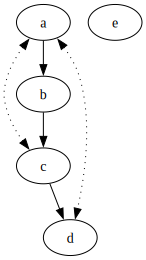

In [6]:
# Voorbeeld a
n = 100000
nodes = ["a", "b", "c", "d", "e"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "a"), ("o1", "c"), ("o2", "a"), ("o2", "d"), ("a", "b"), ("b", "c"), ("c", "d")]

graph_a = DMG(nodes, edges, ommited_nodes)
sigma_try = np.array([[1, 3/4, 2/9, 0, 0], [3/4, 1, 3/4, 0, 0], [2/9, 3/4, 1, 0, 0], [0, 0, 0, 1, 1/2], [0, 0, 0, 1/2, 1]])
print(sigma_try)
graph_a.gen_variable_values(n)
graph_a.estimate_Sigma()
graph_a.estimate_Lambda(sigma_try)
graph_a.estimate_Omega(sigma_try)
print(graph_a.Omega)
print(graph_a.Omega_est)
print(graph_a.Lambda)
print(graph_a.Lambda_est)

vizualize_graph(graph_a)


[[ 0.     0.    -0.203  1.235]
 [-0.337  0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]

[[ 0.     0.    -0.203  1.235]
 [-0.337  0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]

[[5.54  0.    0.198 1.05 ]
 [0.    4.765 0.    0.   ]
 [0.198 0.    1.425 0.   ]
 [1.05  0.    0.    6.628]]

[[ 5.54  -0.     0.198  1.05 ]
 [-0.     4.765  0.    -0.   ]
 [ 0.198  0.     1.425  0.   ]
 [ 1.05  -0.    -0.     6.628]]


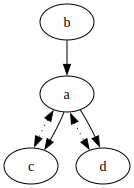

In [21]:
# Voorbeeld b
n = 10000
nodes = ["a", "b", "c", "d"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "a"), ("o1", "c"), ("o2", "a"), ("o2", "d"), ("a", "c"), ("a", "d"), ("b", "a")]

graph_b = DMG(nodes, edges, ommited_nodes)

graph_b.gen_variable_values(n)
graph_b.gen_Sigma()
graph_b.estimate_Sigma()

print_results(graph_b, n)


vizualize_graph(graph_b)


[[ 6.61   0.     0.     7.062]
 [ 0.     6.902  0.     0.   ]
 [ 0.     0.     0.9   -0.103]
 [ 7.062  0.    -0.103 24.552]]
[[ 4.346 -0.     0.    -6.417]
 [-0.     4.765  0.     0.   ]
 [-0.     0.     1.425  0.245]
 [-6.417  0.     0.245 17.669]]
[[ 0.     0.     0.359  0.   ]
 [ 0.     0.     0.    -1.319]
 [ 0.     0.     0.     0.   ]
 [-0.352  0.     0.     0.   ]]
[[ 0.     0.    -0.203  0.   ]
 [ 0.     0.     0.    -0.417]
 [ 0.     0.     0.     0.   ]
 [ 0.81   0.     0.     0.   ]]


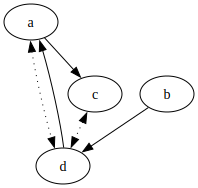

In [28]:
# Voorbeeld c
n = 100000
nodes = ["a", "b", "c", "d"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "a"), ("o1", "d"), ("o2", "c"), ("o2", "d"), ("b", "d"), ("d", "a"), ("a", "c")]

graph_c = DMG(nodes, edges, ommited_nodes)

graph_c.gen_variable_values(n)
graph_c.estimate_Sigma()
graph_c.estimate_Lambda(graph_b.Sigma)
graph_c.estimate_Omega(graph_b.Sigma)
print(graph_c.Omega)
print(graph_c.Omega_est)
print(graph_c.Lambda)
print(graph_c.Lambda_est)
vizualize_graph(graph_c)

1
1

1
1

HTC: True
[[0.    0.615 0.   ]
 [0.    0.    0.354]
 [0.    0.    0.   ]]

[[0.    0.615 0.   ]
 [0.    0.    0.354]
 [0.    0.    0.   ]]

[[2.352 0.    0.84 ]
 [0.    6.98  0.   ]
 [0.84  0.    2.01 ]]

[[2.352 0.    0.84 ]
 [0.    6.98  0.   ]
 [0.84  0.    2.01 ]]


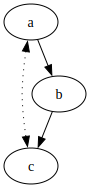

In [20]:
# Voorbeeld d
n = 10000
nodes = ["a", "b", "c"]
ommited_nodes = ["o1"]
edges = [("a", "b"), ("o1", "a"), ("o1", "c"), ("b", "c")]
graph_d = DMG(nodes, edges, ommited_nodes)

print(f"HTC: {graph_d.HTC_identifiable()}")
print_results(graph_d, n)

vizualize_graph(graph_d)


False


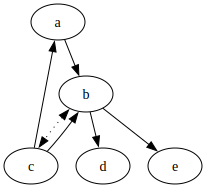

In [43]:
# Voorbeeld d
n = 10000
nodes = ["a", "b", "c", "d", "e"]
ommited_nodes = ["o1"]
edges = [("a", "b"), ("c", "b"), ("b","d"), ("b", "e"), ("o1", "c"), ("o1", "b"), ("c", "a")]
graph_d = DMG(nodes, edges, ommited_nodes)

print(graph_d.HTC_identifiable())
vizualize_graph(graph_d)

In [17]:
n = 100000

# construct graph a
nodes = ["a", "b", "c"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "c"), ("o1", "a")]
graph_b = DMG(nodes, edges, ommited_nodes)



# construct graph b
nodes = ["a", "b", "c", "d", "e"]
ommited_nodes = ["o1", "o2"]
edges = [("o1", "c"), ("o1", "d"), ("o2", "e"), ("o2", "b"), ("a", "e"), ("a", "b"), ("c", "b"), ("c", "e"), ("d", "b"), ("d", "e")]
graph_c = DMG(nodes, edges, ommited_nodes)

data = graph_b.gen_variable_values(n)

sigma_est = graph_b.estimate_Sigma()
print("Estimate Lambda:")
print(graph_c.estimate_Lambda(sigma_est))
print()
print("Estimate Omega:")
print(graph_c.estimate_Omega(sigma_est))
print()
vizualize_graph(graph_c)

Estimate Lambda:
3
3

3
3



IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
############################################################# OLD FUNCTIONS #################################################################

def HTC_Y(self, nodeA):
        parents = nodeA.parents
        siblings = nodeA.siblings
        half_treks = []
        Y = []
        HTC = False
        
        if len(parents) == 0:
            nodeA.set_Yv(Y)
            HTC = True

        for parent in parents:
            parent_treks = []
            
            for variable in self.variables:
                if variable != nodeA and not variable in siblings:
                    var_to_parent = self.get_half_treks(variable, parent)
                    
                    for trek in var_to_parent:
                        parent_treks.append(trek)
            half_treks.append(parent_treks)
        
        combinations = list(itertools.product(*half_treks))

        for comb in combinations:
            if self.sided_interaction(comb) == False and HTC == False:
                for item in comb:
                    Y.append(item[0][0])
                nodeA.set_Yv(Y)
                HTC = True
                
        return nodeA.get_Yv()

def sided_interaction(self, tracks):
    left_side = []
    right_side = []
    
    for track in tracks:
        track_left = [track[0][0]]
        track_right = [track[-1][0]]
        prev_step = track[0]

        for step in track:
            if step[1] == "l" and not prev_step[0] in track_left:
                track_left.append(prev_step[0])
            elif step[1] == "r" and not prev_step[0] in track_right:
                track_right.append(prev_step[0])
            elif step[1] == "b" and not prev_step[0] in track_left:
                track_left.append(prev_step[0])
            
            prev_step = step
            
        left_side += track_left
        right_side += track_right

    unique_left = list(set(left_side))
    unique_right = list(set(right_side))

    if len(unique_left) == len(left_side) and len(unique_right) == len(right_side):
        sided_interaction = False
    else:
        sided_interaction = True

    return sided_interaction